# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from skimage.metrics import structural_similarity as ssim

from collections import Counter

In [2]:
def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

In [23]:
def compare_pictures(orig, compr, labels):
    b_o, g_o, r_o = cv2.split(orig) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    b_c, g_c, r_c = cv2.split(compr)
    new_orig = cv2.merge([r_o, g_o, b_o])
    new_compr = cv2.merge([r_c, g_c, b_c])

    _, axs = plt.subplots(1,2, figsize=(14,5))
    axs[0].imshow(new_orig)
    axs[0].axis('off')
    axs[0].set_title(labels[0])

    axs[1].imshow(new_compr)
    axs[1].axis('off')
    axs[1].set_title(labels[1])
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

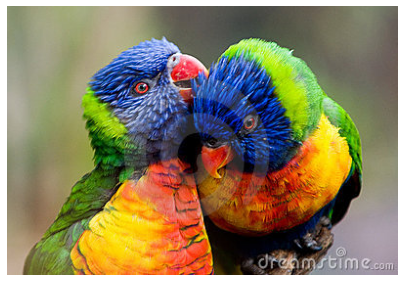

In [3]:
img = cv2.imread("two-lorikeet-birds.jpg") # считать картинку
draw_picture(img) # нарисовать картинку

In [4]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [5]:
n_rows, n_cols = img.shape[:2]
img_2d = np.copy(img).reshape(n_rows*n_cols, 3)

Начнем с k-means

In [7]:
n_clusters = [2, 3, 10, 20]
compressed_imgs_kmeans = []
ssims_kmeans = []
for nc in n_clusters:
    model = KMeans(n_clusters=nc, random_state=42)
    model.fit(img_2d)

    compressed_img = model.cluster_centers_[model.labels_]
    compressed_img = np.clip(compressed_img.astype('uint8'), 0, 255)
    compressed_img = compressed_img.reshape(n_rows, n_cols, 3)
    compressed_imgs_kmeans.append(compressed_img)
    ssims_kmeans.append(ssim(img, compressed_img, data_range=255, multichannel=True))

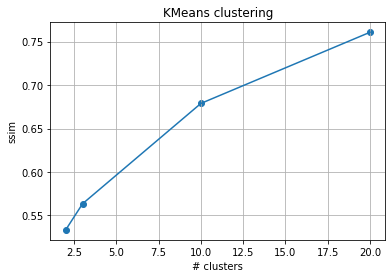

In [8]:
_, ax = plt.subplots()
ax.plot(n_clusters, ssims_kmeans)
ax.scatter(n_clusters, ssims_kmeans)
ax.set_xlabel("# clusters")
ax.set_ylabel("ssim")
ax.set_title("KMeans clustering")
ax.grid()
plt.show()

Как и можно было ожидать, с увеличением числа кластеров метрика улучшается, приближается к 1. Отрисуем сжатую картинку с наилучшим ssim

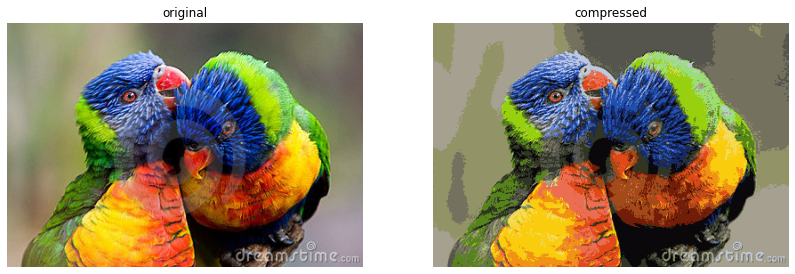

In [24]:
compare_pictures(img, compressed_imgs_kmeans[-1], ['original', 'compressed'])

Перейдем к DBSCAN. У данного алгоритма нельзя задавать количество кластеров, но можно менять два гиперпараметра -- eps (расстояние, на котором две вершины считаются соседями), min_samples (минимальное количество соседей, чтобы считать группу точек кластером)

In [18]:
def get_centroids(X_train, model, algorithm='dbscan'):
    """ Calculate centroids for DBSCAN or AgglomerativeClustering

    :param X_train: data used for training
    :param model: trained model
    """
    assert(algorithm == 'dbscan' or algorithm == 'agglomerative')
    n_clusters = np.size(np.unique(model.labels_))
    cluster_centers = np.zeros((n_clusters,3))
    for k in range(n_clusters):
        if algorithm == 'dbscan':
            cluster_centers[k,:] = np.median(X_train[model.labels_==k-1], axis=0)
        else:
            cluster_centers[k,:] = np.median(X_train[model.labels_==k], axis=0)
    return cluster_centers

In [68]:
epsilons = range(1,16)
minimum_samples = range(5,55,5)
dbscan_param_grid = [(e,ms) for e in epsilons for ms in minimum_samples]
ssims_dbscan = []
compressed_imgs_dbscan = []
n_clusters_dbscan = []
for e, ms in dbscan_param_grid:
    # Train DBSCAN model
    model = DBSCAN(eps=e, min_samples=ms, n_jobs=-1)
    y_pred = model.fit_predict(img_2d)
    n_clusters_db = np.size(np.unique(model.labels_))
    n_clusters_dbscan.append(n_clusters_db)
    
    # Find cluster centroids
    db_centroids = get_centroids(img_2d, model)

    # Construct compressed image
    img_db = db_centroids[model.labels_]
    img_db = np.clip(img_db.astype('uint8'), 0, 255)
    img_db = img_db.reshape(n_rows, n_cols, 3)
    compressed_imgs_dbscan.append(img_db)
    ssims_dbscan.append(ssim(img, img_db, multichannel=True))

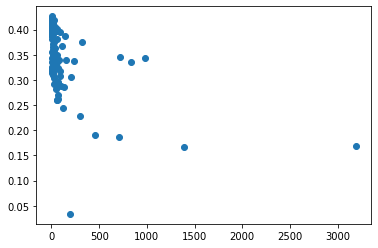

In [69]:
_, ax = plt.subplots()
ax.scatter(n_clusters_dbscan, ssims_dbscan)
plt.show()

In [70]:
t_ = zip(dbscan_param_grid, ssims_dbscan)
best_dbscan_params, best_dbscan_score = max(t_, key=lambda x: x[1])
best_eps, best_min_samples =best_dbscan_params

Number of clusters = 9


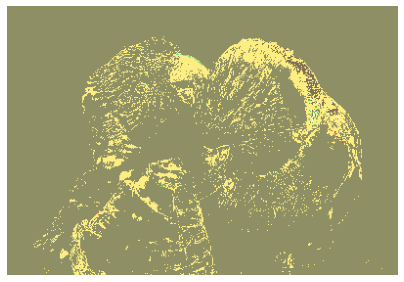

In [71]:
model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
y_pred = model.fit_predict(img_2d)
n_clusters_db = np.size(np.unique(model.labels_))
print(f"Number of clusters = {n_clusters_db}")

db_centroids = get_centroids(img_2d, model)

img_db = db_centroids[model.labels_]
img_db = np.clip(img_db.astype('uint8'), 0, 255)
draw_picture(img_db.reshape(n_rows, n_cols, 3))

К сожалению, результат у DBSCAN не очень.

Рассмотрим Agglomerative Clustering. Требует очень много памяти, поэтому изменим размер картинки.

In [16]:
scaling = 2
n_rows_resized = n_rows//scaling
n_cols_resized = n_cols//scaling
img_resized = cv2.resize(img, (n_cols_resized, n_rows_resized))
img_resized_2d = np.copy(img_resized).reshape(n_rows_resized*n_cols_resized, 3) 

In [19]:
compressed_imgs_aggl = []
ssims_aggl = []
for nc in n_clusters:
    model = AgglomerativeClustering(n_clusters=nc)
    model.fit(img_resized_2d)
    aggl_centroids = get_centroids(img_resized_2d, model, algorithm='agglomerative')

    compressed_img = aggl_centroids[model.labels_]
    compressed_img = np.clip(compressed_img.astype('uint8'), 0, 255)
    compressed_img = compressed_img.reshape(n_rows_resized, n_cols_resized, 3)
    compressed_imgs_aggl.append(compressed_img)
    ssims_aggl.append(ssim(img_resized, compressed_img, data_range=255, multichannel=True))

Сравним `AgglomerativeClustering` с `KMeans`. Для частоты эксперимента применим `KMeans` к resized картинке

In [30]:
compressed_imgs_kmeans = []
ssims_kmeans = []
for nc in n_clusters:
    model = KMeans(n_clusters=nc, random_state=42)
    model.fit(img_resized_2d)

    compressed_img = model.cluster_centers_[model.labels_]
    compressed_img = np.clip(compressed_img.astype('uint8'), 0, 255)
    compressed_img = compressed_img.reshape(n_rows_resized, n_cols_resized, 3)
    compressed_imgs_kmeans.append(compressed_img)
    ssims_kmeans.append(ssim(img_resized, compressed_img, data_range=255, multichannel=True))

Сравним KMeans и AgglomertativeClustering по метрике

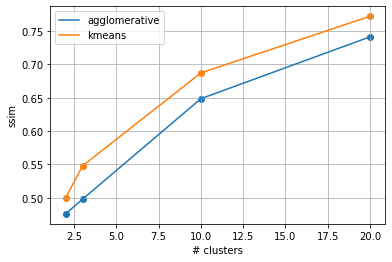

In [31]:
_, ax = plt.subplots()
ax.plot(n_clusters, ssims_aggl, label='agglomerative')
ax.scatter(n_clusters, ssims_aggl)
ax.plot(n_clusters, ssims_kmeans, label='kmeans')
ax.scatter(n_clusters, ssims_kmeans)
ax.set_xlabel("# clusters")
ax.set_ylabel("ssim")
ax.legend()
ax.grid()
plt.show()

Сравним оригинальную и сжатые картинки

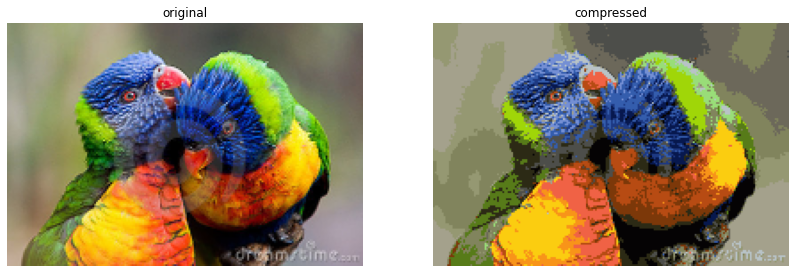

In [32]:
compare_pictures(img_resized, compressed_imgs_aggl[-1], ['original', 'compressed'])

Сравним лучшие результаты `KMeans` и `AgglomerativeClustering` 

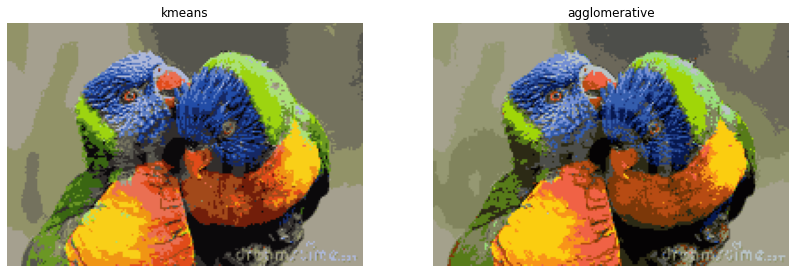

In [33]:
compare_pictures(compressed_imgs_kmeans[-1], compressed_imgs_aggl[-1], ['kmeans', 'agglomerative'])

В целом, для уменьшение политры `KMeans` отлично работает, лучше чем более продвинутые алгоритмы и при этом является самым быстрым. Разочаровал DBSCAN, но может быть он предназначен для других задач.

### Своя картинка

А теперь выясним откуда на белорусь готовилось нападение

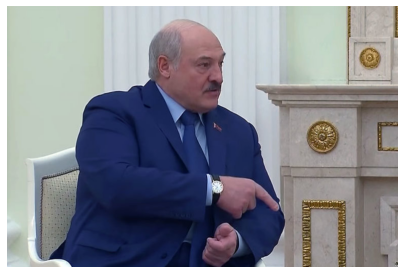

In [34]:
lugabe = cv2.imread("lugabe.jpg") # считать картинку
draw_picture(lugabe) 

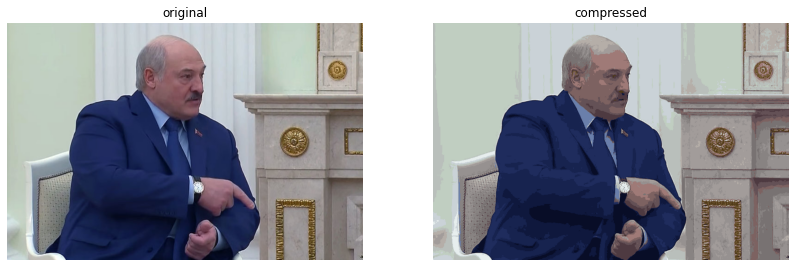

In [35]:
n_rows, n_cols = lugabe.shape[:2]

lugabe_2D = np.copy(lugabe).reshape(n_rows*n_cols, 3)

model = KMeans(n_clusters=20)
model.fit(lugabe_2D)

compressed_lugabe = model.cluster_centers_[model.labels_]
compressed_lugabe = np.clip(compressed_lugabe.astype('uint8'), 0, 255)
compressed_lugabe = compressed_lugabe.reshape(n_rows, n_cols, 3)

compare_pictures(lugabe, compressed_lugabe, ['original', 'compressed']) 

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [33]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [34]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [36]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [37]:
lfw_people.images[0].shape

(125, 94)

In [17]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

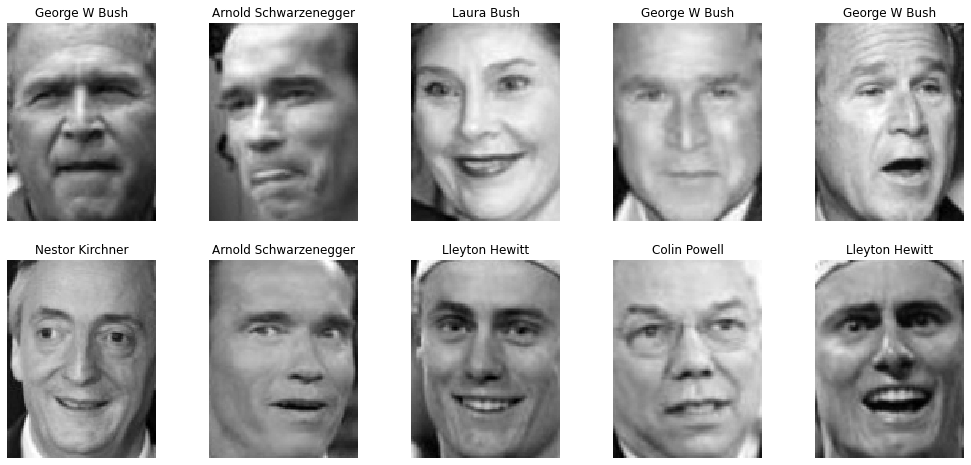

In [40]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

Создадим константный предсказатель

In [41]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train);

Создадим сетку для количества компонентов в PCA, и на трансформированных данных будем тренировать несколько классификаторов

In [72]:
n_components = range(2, 250, 10)
accuracies_lr = []
accuracies_dt = []
accuracies_rf = []
for n in n_components:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    lr = LogisticRegression().fit(X_train_pca, y_train)
    y_pred_lr = lr.predict(X_test_pca)
    accuracies_lr.append(accuracy_score(y_test, y_pred_lr))

    dt = DecisionTreeClassifier().fit(X_train_pca, y_train)
    y_pred_dt = dt.predict(X_test_pca)
    accuracies_dt.append(accuracy_score(y_test, y_pred_dt))

    rf = RandomForestClassifier(n_estimators=200).fit(X_train_pca, y_train)
    y_pred_rf = rf.predict(X_test_pca)
    accuracies_rf.append(accuracy_score(y_test, y_pred_rf))

    

Отрисуем результаты

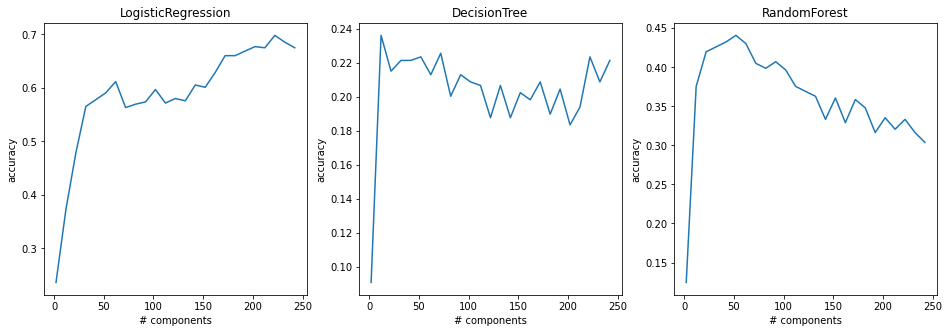

In [75]:
accuracies = [accuracies_lr, accuracies_dt, accuracies_rf]
clfs = ['LogisticRegression', 'DecisionTree', 'RandomForest']
_, axs = plt.subplots(1,3, figsize=(16,5))
for k, ax in enumerate(axs.reshape(-1)):
    ax.plot(n_components, accuracies[k])
    ax.set_xlabel("# components")
    ax.set_ylabel("accuracy")
    ax.set_title(clfs[k])
plt.show()

На удивлегние лучше всех знаменитостей предсказывает логистическая регрессия. На мой взгляд это можно объяснить тем, что лог-регрессия явлется выпуклой проблемой и имеет единственный глобальный минимум, а дерево -- нет. А также признаки могут быть линейно разделяемы. Найдем количество компонентов PCA, при которых скор максимальный

In [84]:
comp_acc = zip(n_components, accuracies_lr)
best_n_comp, best_acc = max(comp_acc, key=lambda x: x[1])

Сравним лучшую модель с константным предсказателем

In [88]:
pca = PCA(n_components=best_n_comp)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lr_clf = LogisticRegression().fit(X_train_pca, y_train)

y_pred_lr = lr_clf.predict(X_test_pca)
print(f"Accuracy of the logistic regression classifier: {accuracy_score(y_test, y_pred_lr):.4f}")

y_pred_dummy = dummy_clf.predict(X_test)
print(f"Accuracy of the dummy classifier: {accuracy_score(y_test, y_pred_dummy):.4f}")

Accuracy of the logistic regression classifier: 0.6941
Accuracy of the dummy classifier: 0.2384


Обученная модель существенно лучше константного классификатора. Для уменьшение размерности я воспользовался PCA, вместо TSNE. Во первых, TSNE уменьшает размерность до максимум 3 компонент, что скорее всего недостаточно для нашей задачи, где изначальная размерность признаков более 11К. Во вторых, невозможно обучить TSNE на тренировочной выборке, а потом применить к  тестовой, TSNE не находить отображение из высокоразмерного пространства в низкоразмерное. Если мы применим TSNE ко всей выборке, что может произойти data leakage


Теперь отрисуем лица, на которых модель ошиблась

In [93]:
X_test_misclas = X_test[y_test!=y_pred_lr]
y_test_misclas = y_test[y_test!=y_pred_lr]
y_pred_misclas = y_pred_lr[y_test!=y_pred_lr]

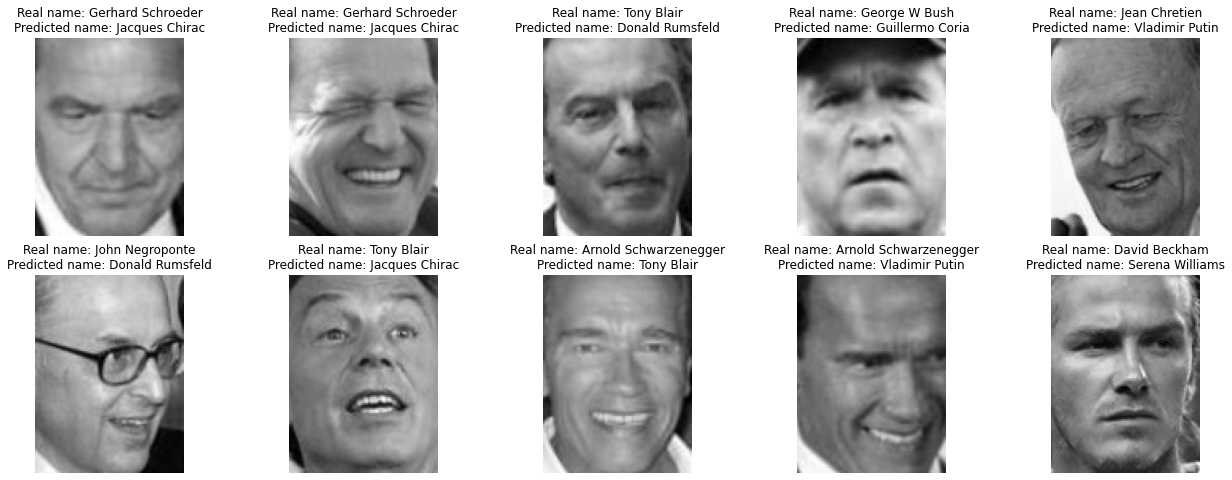

In [102]:
_, axs = plt.subplots(2,5, figsize=(22,8))
for k, ax in enumerate(axs.reshape(-1)):
    ax.imshow(255-X_test_misclas[k,:].reshape(125,94), cmap=plt.cm.gray_r)
    ax.set_title('Real name: ' + names[y_test_misclas[k]] + 
                    '\n'+'Predicted name: ' + names[y_pred_misclas[k]])
    ax.axis('off')

Визуализируем данные. Для этого воспользуемся алгоритмом TSNE, потому что он нелинейный и лучше разделяет данные при уменьшении размерности

In [126]:
X_train_tsne = TSNE(n_components=2).fit_transform(X_train)

In [129]:
most_famous = sorted(Counter(y_train).items(), key=lambda x: x[1], reverse=True)[:5]
most_famous_names = [names[item[0]] for item in most_famous]
X_tsne_famous = [X_train_tsne[y_train==item[0]] for item in most_famous]

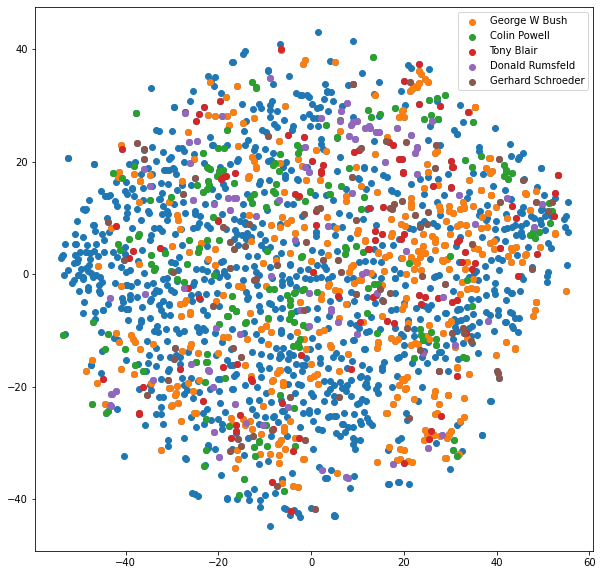

In [135]:
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train_tsne[:,0], X_train_tsne[:,1])
for k, item in enumerate(X_tsne_famous):
    ax.scatter(item[:,0], item[:,1], label=most_famous_names[k])
ax.legend()
plt.show()

К сожалению, выборки, которые обозначают одних и тех же людей разбросаны по всей плоскости